In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import itertools
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller, kpss


import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

from scipy.linalg import eigh

import plotly.graph_objects as go
from ipywidgets import interact

import preprocess
import info_theory
import stationarity_tests
import network
import backboning
import plotting

In [31]:
# Define assets and file paths
assets = ["commodity", "credit", "currency", "energy", "equity", "interest", "metals", "real_estate", "volatility"]
file_paths = {asset: f"../data/{asset}_data.xlsx" for asset in assets}

# Load data
aligned_data, tickers = preprocess.load_and_align_data(file_paths)

# Drop tickers with many missing points
aligned_data, tickers = preprocess.drop_short_tickers(aligned_data, tickers, max_nan=50)
aligned_data['GB03'] + 0.1
# Compute log returns
log_returns = preprocess.compute_log_returns(aligned_data)

# Interest data has negative and zero values
#interest_data = aligned_data[tickers['interest']]
#log_returns[tickers["interest"]] = interest_data

# Drop NA
log_returns = log_returns.dropna()

Tickers to drop/replace due to insufficient data:
['FXJPEMCS', 'QCLN']


c:\Users\akhma\OneDrive\Onenote\Python\my_venv\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning:

invalid value encountered in log



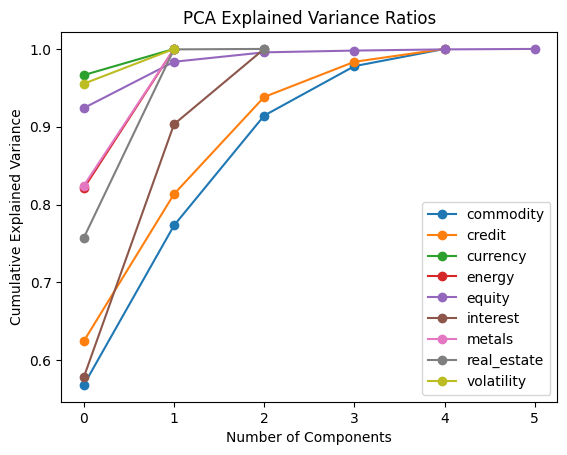

In [23]:
asset_classes_discrete = preprocess.pca_and_discretize(log_returns, tickers, plot_explained_var_ratio=True)

In [24]:
asset_classes_discrete

,commodity,credit,currency,energy,equity,interest,metals,real_estate,volatility
Date,,,,,,,,,
2005-01-04,4,5,10,7,5,7,6,6,7
2005-01-05,7,7,7,6,6,6,6,5,7
2005-01-06,6,6,8,8,7,6,6,7,6
2005-01-07,8,6,7,6,6,7,6,7,6
2005-01-10,7,7,6,7,7,7,7,6,7
...,...,...,...,...,...,...,...,...,...
2024-11-12,4,5,9,6,6,7,3,5,7
2024-11-13,6,6,7,7,6,6,6,6,6
2024-11-14,6,7,7,7,6,7,6,6,7


In [5]:
window_len = 1
window_step = 6
windows = preprocess.sliding_window(asset_classes_discrete, 
                                    window_len, 
                                    window_step, 
                                    window_unit="years", 
                                    step_unit="months")
endpoints = [end_date for _, end_date, _ in windows]

In [6]:
X = np.random.randint(0, 2, 1000)
Y = np.random.randint(0, 2, 1000)

print(info_theory.transfer_entropy(X, Y, k=1, l=1))


0.00043885821358761144


In [7]:
def eff_measure(X, Y, measure, n_surrogates=10, *args, **kwargs):
    observed = measure(X, Y, *args, **kwargs)
    random_results = []
    for _ in range(n_surrogates):
        shift = np.random.randint(len(X))
        X_shifted = np.roll(X, shift)
        random_results.append(measure(X_shifted, Y, *args, **kwargs))
    return observed - np.mean(random_results)

In [8]:
def eff_transfer_entropy(X, Y, n_surrogates=10, k=1, l=1):
    observed_te = info_theory.transfer_entropy(X, Y, k=k, l=l)
    random_te = []
    for _ in range(n_surrogates):
        shift = np.random.randint(len(X))
        X_shifted = np.roll(X, shift)
        random_te.append(info_theory.transfer_entropy(X_shifted, Y, k=k, l=l))
    return observed_te - np.mean(random_te)

In [9]:
def random_surrogate_measure(X, Y, measure, n_surrogates=10, plot_surrogate_distribution=False, *args, **kwargs):
    random_results = []
    for _ in range(n_surrogates):
        shift = np.random.randint(len(X))
        X_shifted = np.roll(X, shift)
        random_results.append(measure(X_shifted, Y, *args, **kwargs))
    
    if plot_surrogate_distribution:
        plt.hist(random_results)

    return random_results


In [10]:
def eff_mi(X, Y, n_surrogates=10):
    observed_mi = info_theory.MI(X, Y)
    random_mi = []
    for _ in range(n_surrogates):
        shift = np.random.randint(len(X))
        X_shifted = np.roll(X, shift)
        random_mi.append(info_theory.MI(X_shifted, Y))
    return observed_mi - np.mean(random_mi)

0.09132663983450984
0.005956499598492607
0.0018759859720472068
0.006167338846717552


[np.float64(0.08904688022112224),
 np.float64(0.08895704926186591),
 np.float64(0.08127846154509748),
 np.float64(0.08754449629651094),
 np.float64(0.08652495521326313),
 np.float64(0.09423626449879029),
 np.float64(0.08670131221024556),
 np.float64(0.07551067054361223),
 np.float64(0.08147779813990493),
 np.float64(0.09578665576760734),
 np.float64(0.08847445417976674),
 np.float64(0.08424221723126896),
 np.float64(0.08705130907201178),
 np.float64(0.0850402321258593),
 np.float64(0.09090714024707473),
 np.float64(0.08269250917209162),
 np.float64(0.08251821845143971),
 np.float64(0.08483729042600956),
 np.float64(0.08701718618692542),
 np.float64(0.08710331565786705),
 np.float64(0.08855598052368127),
 np.float64(0.08655751719449456),
 np.float64(0.08752164211953292),
 np.float64(0.08628040226752322),
 np.float64(0.08168663050390886),
 np.float64(0.09084598466761581),
 np.float64(0.08593187321581201),
 np.float64(0.08510890698334529),
 np.float64(0.08979266407448147),
 np.float64(0.0

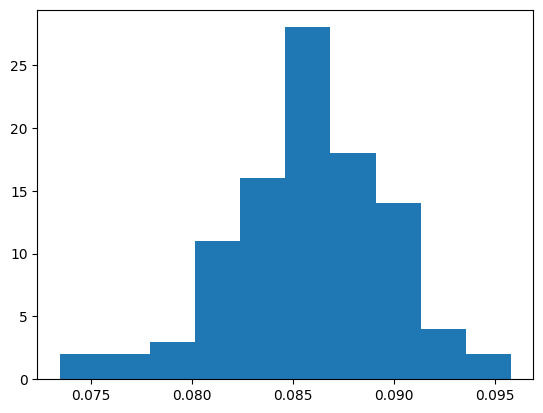

In [11]:
X = np.random.randint(0, 10, 5000)
Y = np.random.randint(0, 10, 5000)

print(info_theory.transfer_entropy(X, Y, k=1, l=1))
print(eff_transfer_entropy(X, Y, 100))
print(eff_mi(X, Y, 100))
print(eff_measure(X, Y, info_theory.transfer_entropy, n_surrogates=100, k=1, l=1))
random_surrogate_measure(X, Y, info_theory.transfer_entropy, n_surrogates=100, plot_surrogate_distribution=True, k=1, l=1)

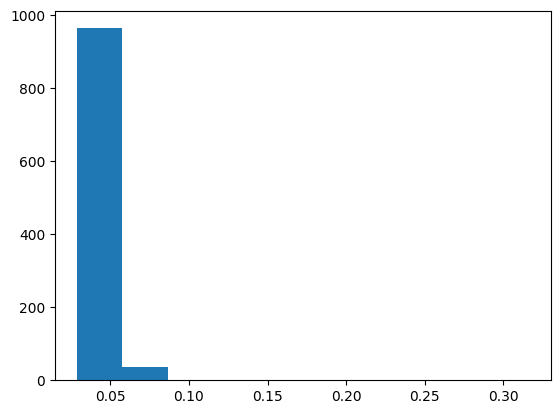

In [13]:
X = asset_classes_discrete['real_estate'].values
Y = asset_classes_discrete['equity'].values
random_results = random_surrogate_measure(X, Y, info_theory.transfer_entropy, n_surrogates=1000, plot_surrogate_distribution=True, k=1, l=1)

In [14]:
threshold = np.percentile(random_results, 90)
print(threshold)

0.04879617398349596


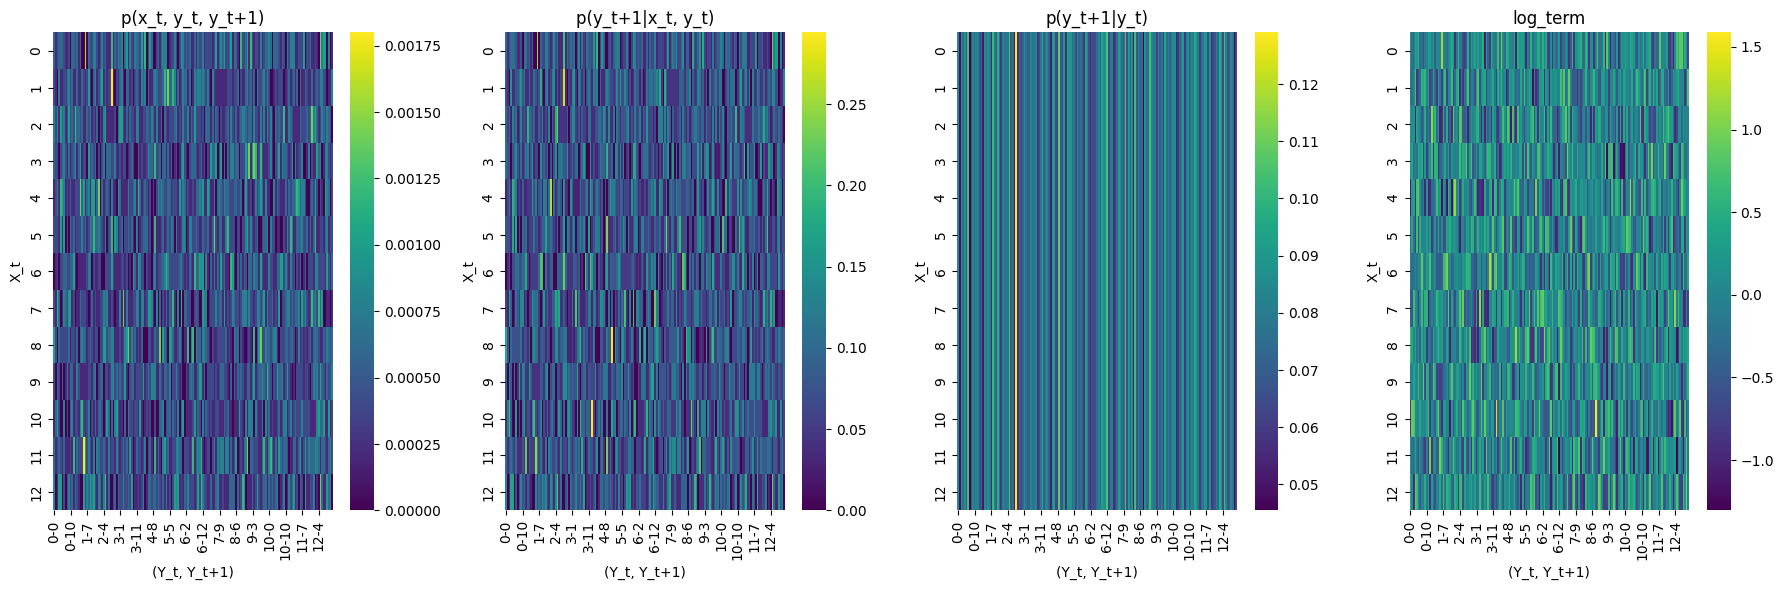

Transfer Entropy: 0.212431


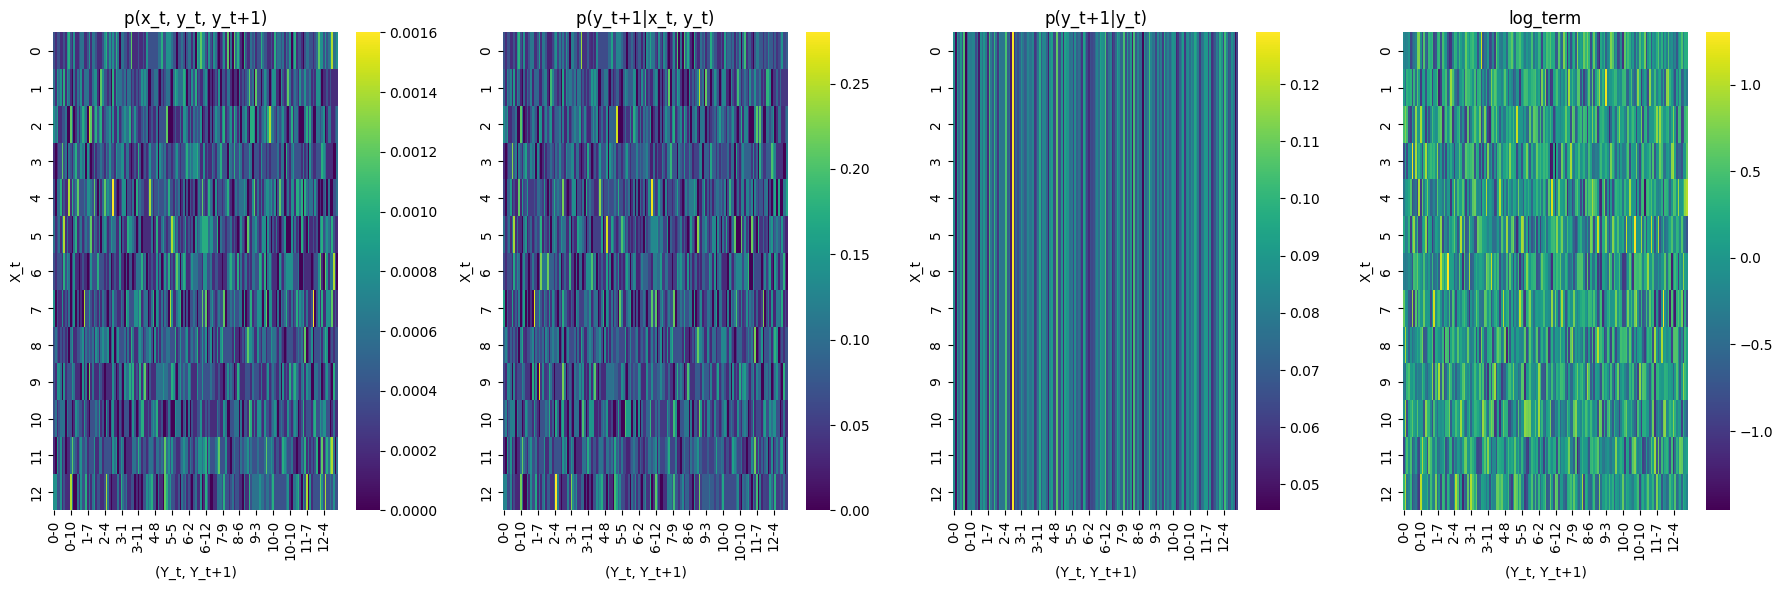

Transfer Entropy: 0.20526263125787542


In [25]:
import seaborn as sns
from itertools import product

def transfer_entropy(X, Y, k, l=1, probabilities=True, plot_diagnostics=False):
    """
    Compute the transfer entropy from X to Y with visualization capabilities.
    """
    N = len(X)
    m = max(k, l)

    # Numpy sliding window is faster than repeated slicing
    def sliding_window(arr, window_size):
        shape = (arr.size - window_size + 1, window_size)
        strides = (arr.strides[0], arr.strides[0])
        return np.lib.stride_tricks.as_strided(arr, shape=shape, strides=strides)

    # Generate windows
    x_windows = sliding_window(X, k)
    y_windows = sliding_window(Y, l)
    x_pasts = x_windows[m - k : N - k]
    y_pasts = y_windows[m - l : N - l]
    y_futures = sliding_window(Y, 1)[m : N]

    # Combine into single array
    xyy = np.hstack((x_pasts, y_pasts, y_futures))

    # Get unique events and counts
    xyy_unique, xyy_counts = np.unique(xyy, return_counts=True, axis=0)
    xy_unique, xy_counts = np.unique(xyy[:, :-1], return_counts=True, axis=0)
    yy_unique, yy_counts = np.unique(xyy[:, k:], return_counts=True, axis=0)
    y_unique, y_counts = np.unique(xyy[:, k:k+l], return_counts=True, axis=0)

    # Create dictionaries for counts
    def counts_dict(unique, counts):
        return {tuple(event): count for event, count in zip(unique, counts)}
    
    xy_dict = counts_dict(xy_unique, xy_counts)
    yy_dict = counts_dict(yy_unique, yy_counts)
    y_dict = counts_dict(y_unique, y_counts)

    # Collect probabilities
    d = {
        'x_t': [],
        'y_t': [],
        'y_t+1': [],
        'p(x_t, y_t, y_t+1)': [],
        'p(y_t+1|x_t, y_t)': [],
        'p(y_t+1|y_t)': []
    }

    TE = 0
    total_counts = np.sum(xyy_counts)
    
    for event, count in zip(xyy_unique, xyy_counts):
        x_past = tuple(event[:k])
        y_past = tuple(event[k:k+l])
        y_future = event[-1]

        # p(x_past, y_past, y_future)
        p_xyy = count / total_counts
        
        # Get keys
        xy_key = tuple(np.hstack((x_past, y_past)))
        yy_key_future = tuple(np.hstack((y_past, y_future)))
        yy_key_past = tuple(y_past)
        
        # p(y_future | x_past, y_past)
        condp_xy = count / xy_dict[xy_key]

        # p(y_future | y_past)
        condp_y = yy_dict[yy_key_future] / y_dict[yy_key_past]

        # Store values
        d['x_t'].append(x_past)
        d['y_t'].append(y_past)
        d['y_t+1'].append(y_future)
        d['p(x_t, y_t, y_t+1)'].append(p_xyy)
        d['p(y_t+1|x_t, y_t)'].append(condp_xy)
        d['p(y_t+1|y_t)'].append(condp_y)

        # Calculate TE
        if condp_xy > 0 and condp_y > 0:
            TE += p_xyy * (np.log(condp_xy) - np.log(condp_y))

    d['log_term'] = np.log(d['p(y_t+1|x_t, y_t)']) - np.log(d['p(y_t+1|y_t)'])
    df = pd.DataFrame(d)

    if probabilities:
        """
        Assuming source and destination past history and delay are 1, we have
        TE_{X->Y}(1, 1, 1) = \sum p(y_t+1, y_t, x_t) log(p(y_t+1|y_t, x_t)/p(y_t+1|y_t))
        Sum is over possible triples (y_t+1, y_t, x_t). 
        Plot heatmaps of the joint and conditional distributions in the formula.
        """
        # Generate all possible events (to visualise the whole sample space)
        possible_x = np.unique(X)
        possible_y = np.unique(Y)
        
        all_events = []
        for x_past in product(possible_x, repeat=k):
            for y_past in product(possible_y, repeat=l):
                for y_future in possible_y:
                    all_events.append({
                        'x_t': x_past,
                        'y_t': y_past,
                        'y_t+1': y_future
                    })
        
        complete_df = pd.DataFrame(all_events)
        
        # Merge with calculated probabilities (events that happened in the data)
        merged_df = complete_df.merge(
            df, 
            on=['x_t', 'y_t', 'y_t+1'], 
            how='left'
        ).fillna(0)  # events that did not happen are filled with 0
        
        """
        For the third plot, the 0 values makes it appear that there is dependency on X_t.
        Fix this by precomputing p(y_t+1|y_t) independent of X_t and overwriting the 
        corresponding column of the dataframe.
        """
        # Precompute p(y_t+1|y_t) independent of X_t
        condp_y_dict = {}
        for yy_row, count in zip(yy_unique, yy_counts):  
            y_past = tuple(yy_row[:l])  
            y_future = yy_row[-1]       # Last element is y_future
            condp_y = count / y_dict[y_past]
            condp_y_dict[(y_past, y_future)] = condp_y

        # Replace p(y_t+1|y_t) column with precomputed values 
        merged_df['p(y_t+1|y_t)'] = merged_df.apply(
            lambda row: condp_y_dict.get((tuple(row['y_t']), row['y_t+1']), 0),
            axis=1
        )

    if plot_diagnostics:
        # Create plots
        fig, axs = plt.subplots(1, 4, figsize=(18, 6))
        
        # Helper function to plot heatmaps
        def plot_heatmap(data, ax, title):
            if k == 1 and l == 1:
                # Convert tuples to scalar values
                data['x'] = data['x_t'].apply(lambda x: x[0])
                data['y'] = data['y_t'].apply(lambda y: y[0])
                pivot = data.pivot_table(
                    index='x', 
                    columns=['y', 'y_t+1'], 
                    values=title,
                    fill_value=0
                )
                sns.heatmap(pivot, ax=ax, cmap='viridis', annot=False, fmt=".2f")
                ax.set_title(title)
                ax.set_xlabel('(Y_t, Y_t+1)')
                ax.set_ylabel('X_t')
        
        # Plot each probability
        plot_heatmap(merged_df, axs[0], 'p(x_t, y_t, y_t+1)')
        plot_heatmap(merged_df, axs[1], 'p(y_t+1|x_t, y_t)')
        plot_heatmap(merged_df, axs[2], 'p(y_t+1|y_t)')
        plot_heatmap(merged_df, axs[3], 'log_term')

        plt.tight_layout()
        plt.show()

    return TE, merged_df

# Test on iid discrete uniform random variables
# Discretized asset class data has 13 bins and around 4900 points
np.random.seed(42)
X = np.random.randint(0, 13, 5000)
Y = np.random.randint(0, 13, 5000)

TE_value, _ = transfer_entropy(X, Y, k=1, l=1, probabilities= True, plot_diagnostics=True)
print(f"Transfer Entropy: {TE_value:.6f}")

shift = np.random.randint(len(X))
X_shifted = np.roll(X, shift)
TE_value, _ = transfer_entropy(X_shifted, Y, k=1, l=1, probabilities=True, plot_diagnostics=True)
print("Transfer Entropy:", TE_value)

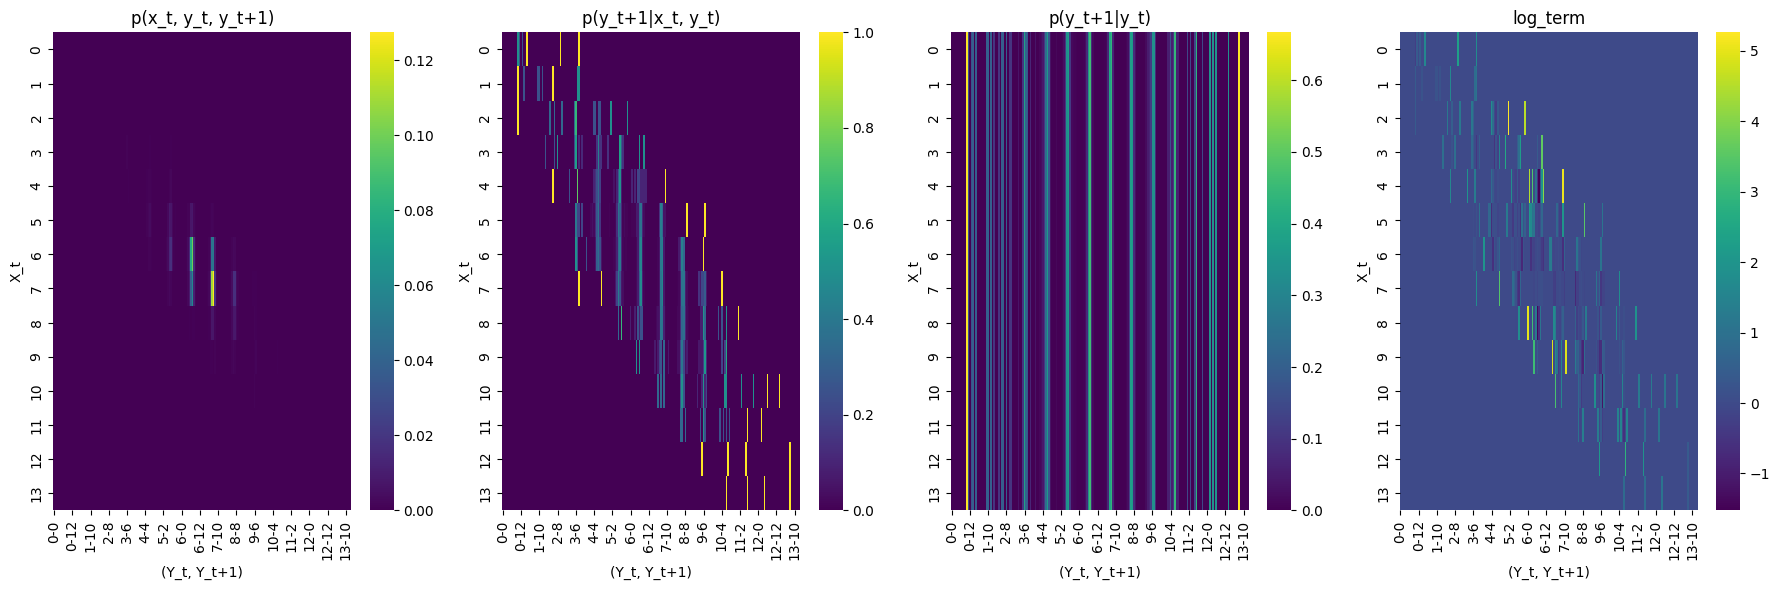

Transfer Entropy: 0.05074467760664857
4415


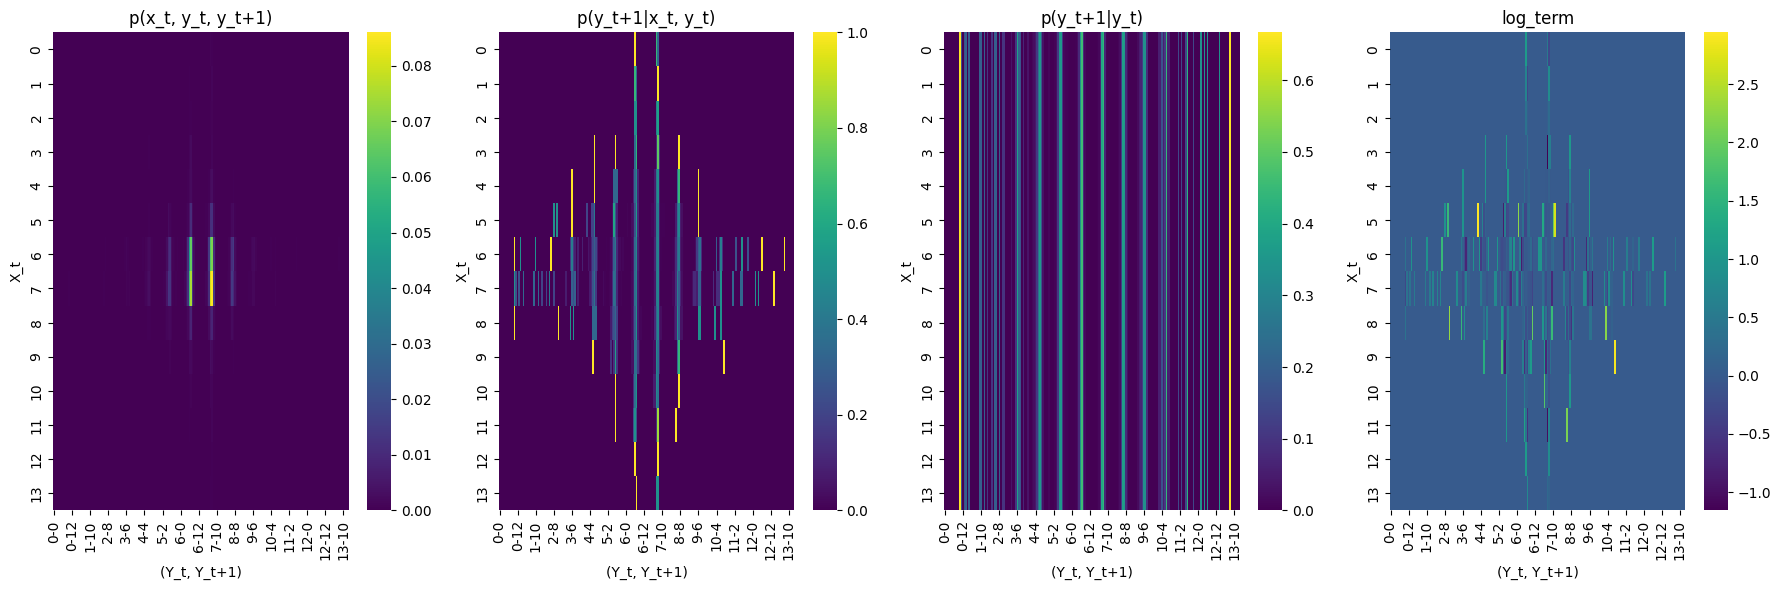

Transfer Entropy: 0.03485268037774743


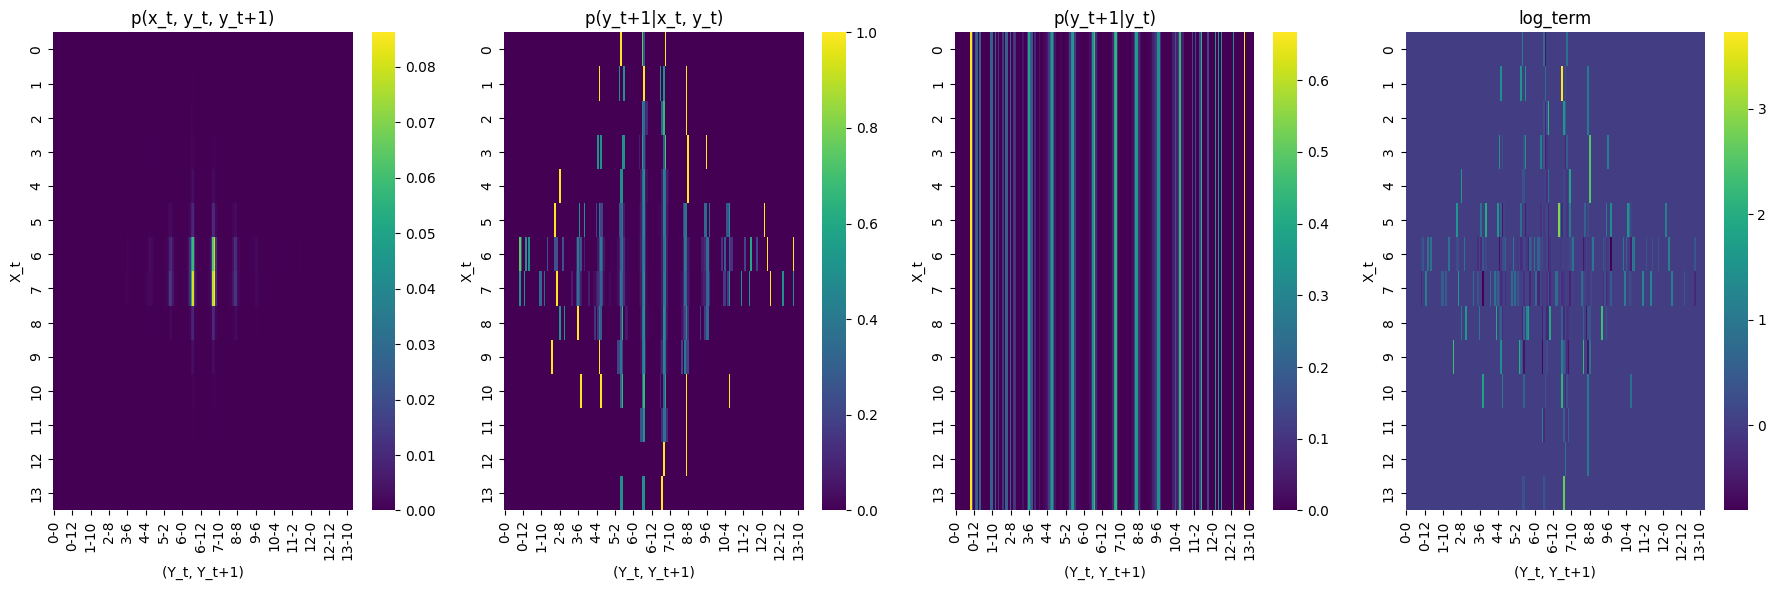

Transfer Entropy: 0.03813691352673469


In [26]:
X = asset_classes_discrete['real_estate'].values
Y = asset_classes_discrete['equity'].values
TE_value, _ = transfer_entropy(X, Y, k=1, l=1, probabilities=True, plot_diagnostics=True)
print("Transfer Entropy:", TE_value)

shift = np.random.randint(len(X))
print(shift)
X_shifted = np.roll(X, shift)
TE_value, _ = transfer_entropy(X_shifted, Y, k=1, l=1, probabilities=True, plot_diagnostics=True)
print("Transfer Entropy:", TE_value)

X_shuffled = np.random.permutation(X)
TE_value, _ = transfer_entropy(X_shuffled, Y, k=1, l=1, probabilities=True, plot_diagnostics=True)
print("Transfer Entropy:", TE_value)

In [27]:
import shutil
import os

In [18]:
asset_classes_discrete.columns

Index(['commodity', 'credit', 'currency', 'energy', 'equity', 'interest',
       'metals', 'real_estate', 'volatility'],
      dtype='object')

In [28]:
def te_plot_probabilities(asset_classes_discrete, output_folder, k=1, l=1):
    """
    Compute transfer entropy for all permutations of asset class pairs,
    generate combined diagnostic plots, and save outputs in the specified folder.
    """
    # Clear and create the output folder
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder)

    # Get the list of asset classes
    assets = asset_classes_discrete.columns
    asset_pairs = list(itertools.permutations(assets, 2))

    # Loop over all asset pairs
    for asset1, asset2 in asset_pairs:
        print(f"Processing {asset1} -> {asset2}")

        # Extract time series for the current pair
        X = asset_classes_discrete[asset1].values
        Y = asset_classes_discrete[asset2].values

        # Define 3x4 figure 
        fig, axs = plt.subplots(3, 4, figsize=(24, 18), sharey=True)

        # Compute TE and diagnostics for original data 
        TE_original, merged_df = transfer_entropy(X, Y, k=k, l=l, probabilities=True, plot_diagnostics=False)

        # Shifted data
        shift = np.random.randint(len(X))
        X_shifted = np.roll(X, shift)
        TE_shifted, merged_df_shifted = transfer_entropy(X_shifted, Y, k=k, l=l, 
                                                         probabilities=True, plot_diagnostics=False)
        
        # Shuffled data
        X_shuffled = np.random.permutation(X)
        TE_shuffled, merged_df_shuffled = transfer_entropy(X_shuffled, Y, k=k, l=l, 
                                                         probabilities=True, plot_diagnostics=False)

        # Helper function to plot heatmaps
        def plot_heatmap(data, ax, title):
            if k == 1 and l == 1:
                # Convert tuples to scalar values
                data['x'] = data['x_t'].apply(lambda x: x[0])
                data['y'] = data['y_t'].apply(lambda y: y[0])
                pivot = data.pivot_table(
                    index='x',
                    columns=['y', 'y_t+1'],
                    values=title,
                    fill_value=0
                )
                sns.heatmap(pivot, ax=ax, cmap='viridis', annot=False, fmt=".2f")
                ax.set_title(title)
                ax.set_xlabel('(Y_t, Y_t+1)')
                ax.set_ylabel('X_t')

        # Plot original data
        plot_heatmap(merged_df, axs[0, 0], 'p(x_t, y_t, y_t+1)')
        plot_heatmap(merged_df, axs[0, 1], 'p(y_t+1|x_t, y_t)')
        plot_heatmap(merged_df, axs[0, 2], 'p(y_t+1|y_t)')
        plot_heatmap(merged_df, axs[0, 3], 'log_term')

        # Plot shifted data
        plot_heatmap(merged_df_shifted, axs[1, 0], 'p(x_t, y_t, y_t+1)')
        plot_heatmap(merged_df_shifted, axs[1, 1], 'p(y_t+1|x_t, y_t)')
        plot_heatmap(merged_df_shifted, axs[1, 2], 'p(y_t+1|y_t)')
        plot_heatmap(merged_df_shifted, axs[1, 3], 'log_term')

        # Plot shuffled data
        plot_heatmap(merged_df_shuffled, axs[2, 0], 'p(x_t, y_t, y_t+1)')
        plot_heatmap(merged_df_shuffled, axs[2, 1], 'p(y_t+1|x_t, y_t)')
        plot_heatmap(merged_df_shuffled, axs[2, 2], 'p(y_t+1|y_t)')
        plot_heatmap(merged_df_shuffled, axs[2, 3], 'log_term')

        # Add main title for the entire figure
        fig.suptitle(f"{asset1} -> {asset2}", fontsize=16)

        # Adjust layout and save the figure
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
        plt.savefig(os.path.join(output_folder, f"{asset1}_to_{asset2}_combined_plots.png"))
        plt.close()

        print(f"Saved results for {asset1} -> {asset2}")

In [29]:
te_plot_probabilities(asset_classes_discrete, "te_probabilities")

Processing commodity -> credit
Saved results for commodity -> credit
Processing commodity -> currency
Saved results for commodity -> currency
Processing commodity -> energy
Saved results for commodity -> energy
Processing commodity -> equity
Saved results for commodity -> equity
Processing commodity -> interest
Saved results for commodity -> interest
Processing commodity -> metals
Saved results for commodity -> metals
Processing commodity -> real_estate
Saved results for commodity -> real_estate
Processing commodity -> volatility
Saved results for commodity -> volatility
Processing credit -> commodity
Saved results for credit -> commodity
Processing credit -> currency
Saved results for credit -> currency
Processing credit -> energy
Saved results for credit -> energy
Processing credit -> equity
Saved results for credit -> equity
Processing credit -> interest
Saved results for credit -> interest
Processing credit -> metals
Saved results for credit -> metals
Processing credit -> real_esta

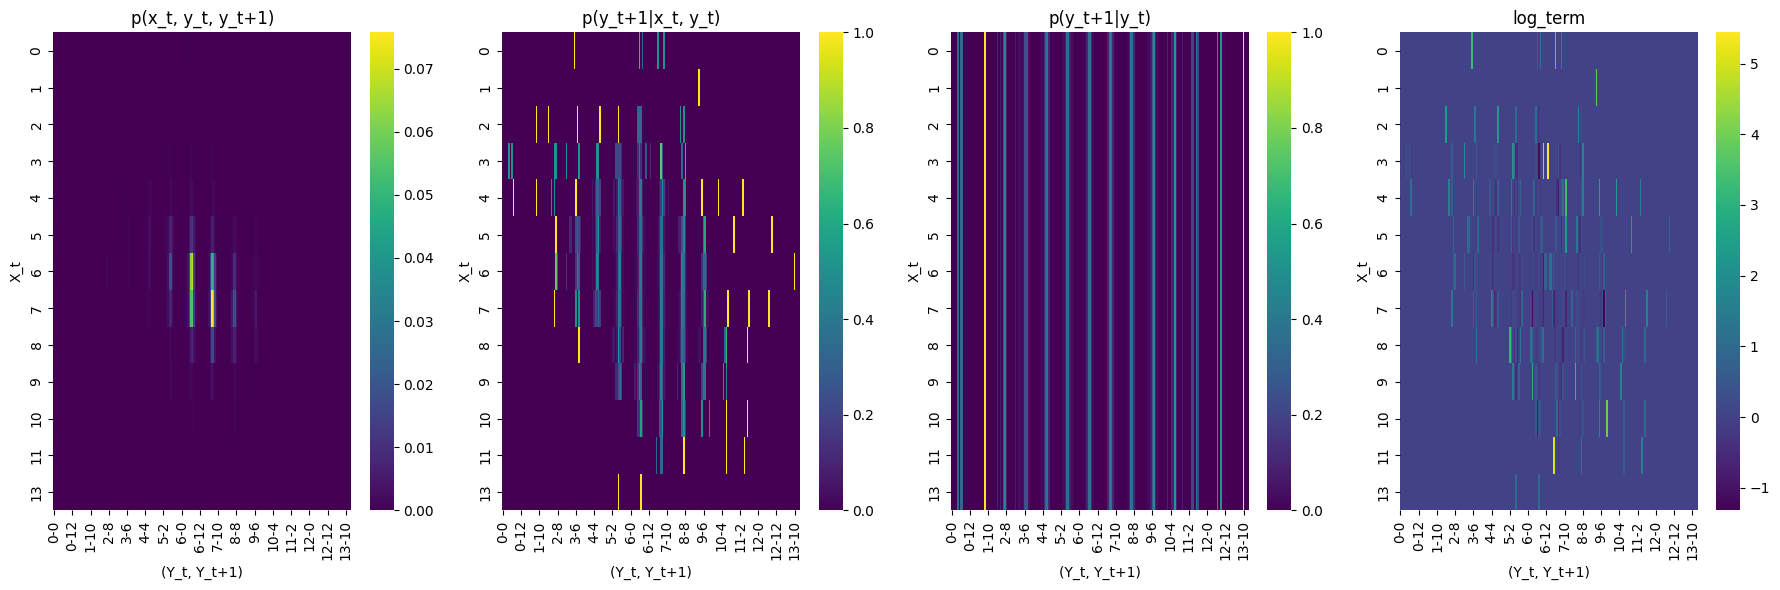

Transfer Entropy: (np.float64(0.04370728656495729),         x_t    y_t  y_t+1  p(x_t, y_t, y_t+1)  p(y_t+1|x_t, y_t)  \
0      (0,)   (0,)      0                 0.0                0.0   
1      (0,)   (0,)      1                 0.0                0.0   
2      (0,)   (0,)      2                 0.0                0.0   
3      (0,)   (0,)      3                 0.0                0.0   
4      (0,)   (0,)      4                 0.0                0.0   
...     ...    ...    ...                 ...                ...   
2543  (13,)  (13,)      9                 0.0                0.0   
2544  (13,)  (13,)     10                 0.0                0.0   
2545  (13,)  (13,)     11                 0.0                0.0   
2546  (13,)  (13,)     12                 0.0                0.0   
2547  (13,)  (13,)     13                 0.0                0.0   

      p(y_t+1|y_t)  log_term   x   y  
0         0.000000       0.0   0   0  
1         0.000000       0.0   0   0  
2         0.00

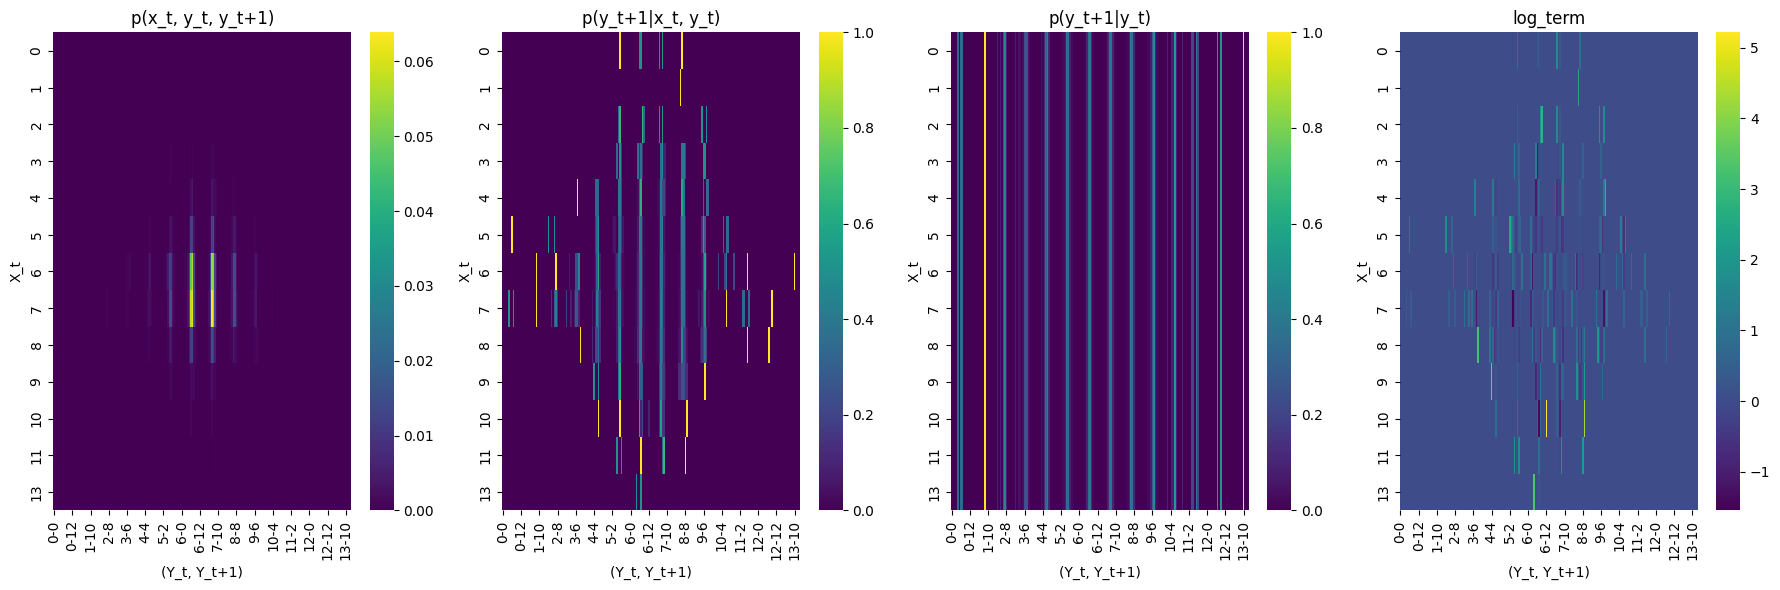

Transfer Entropy: (np.float64(0.04358426474213858),         x_t    y_t  y_t+1  p(x_t, y_t, y_t+1)  p(y_t+1|x_t, y_t)  \
0      (0,)   (0,)      0                 0.0                0.0   
1      (0,)   (0,)      1                 0.0                0.0   
2      (0,)   (0,)      2                 0.0                0.0   
3      (0,)   (0,)      3                 0.0                0.0   
4      (0,)   (0,)      4                 0.0                0.0   
...     ...    ...    ...                 ...                ...   
2543  (13,)  (13,)      9                 0.0                0.0   
2544  (13,)  (13,)     10                 0.0                0.0   
2545  (13,)  (13,)     11                 0.0                0.0   
2546  (13,)  (13,)     12                 0.0                0.0   
2547  (13,)  (13,)     13                 0.0                0.0   

      p(y_t+1|y_t)  log_term   x   y  
0         0.000000       0.0   0   0  
1         0.000000       0.0   0   0  
2         0.00

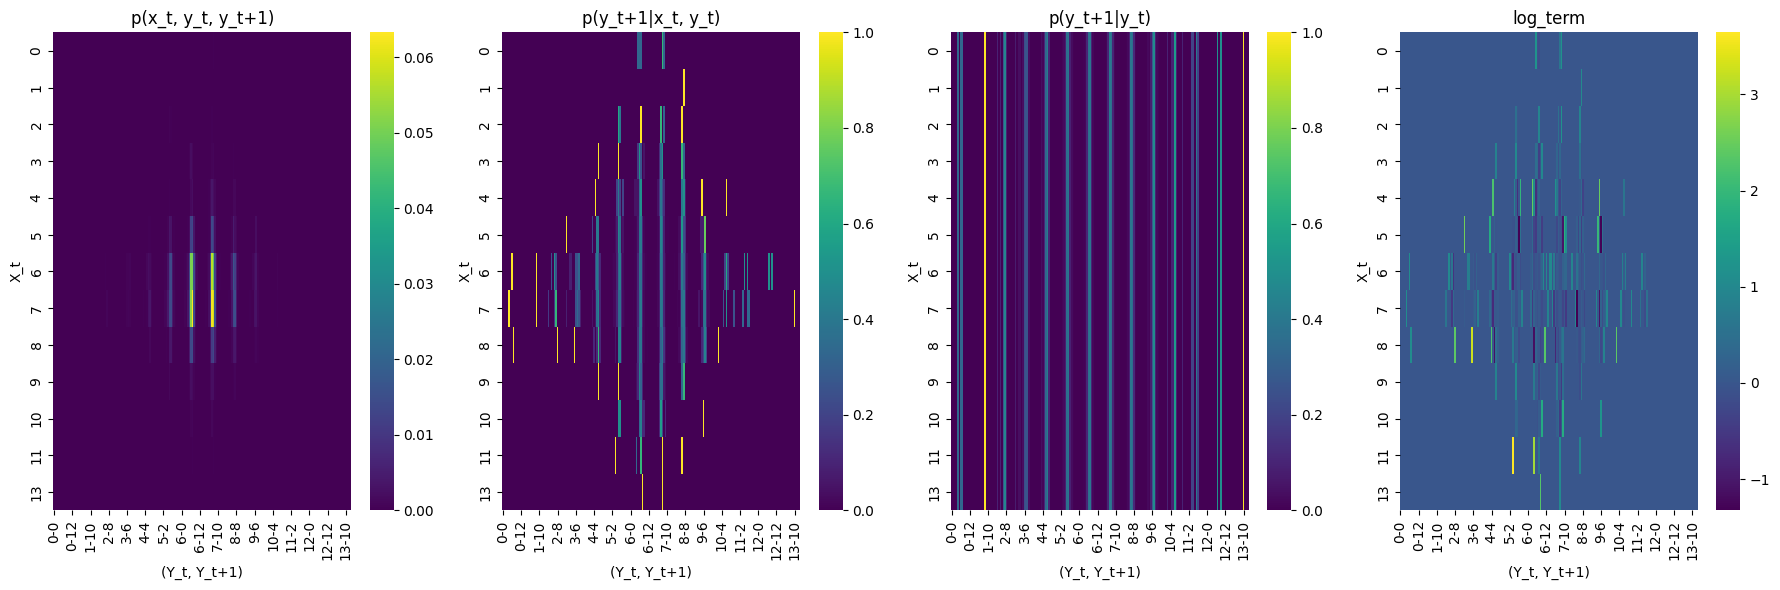

Transfer Entropy: (np.float64(0.03662987717181106),         x_t    y_t  y_t+1  p(x_t, y_t, y_t+1)  p(y_t+1|x_t, y_t)  \
0      (0,)   (0,)      0                 0.0                0.0   
1      (0,)   (0,)      1                 0.0                0.0   
2      (0,)   (0,)      2                 0.0                0.0   
3      (0,)   (0,)      3                 0.0                0.0   
4      (0,)   (0,)      4                 0.0                0.0   
...     ...    ...    ...                 ...                ...   
2543  (13,)  (13,)      9                 0.0                0.0   
2544  (13,)  (13,)     10                 0.0                0.0   
2545  (13,)  (13,)     11                 0.0                0.0   
2546  (13,)  (13,)     12                 0.0                0.0   
2547  (13,)  (13,)     13                 0.0                0.0   

      p(y_t+1|y_t)  log_term   x   y  
0         0.000000       0.0   0   0  
1         0.000000       0.0   0   0  
2         0.00

In [26]:
X = asset_classes_discrete['commodity'].values
Y = asset_classes_discrete['metals'].values
TE_value = transfer_entropy(X, Y, k=1, l=1, plot_diagnostics=True)
print("Transfer Entropy:", TE_value)

shift = np.random.randint(len(X))
print(shift)
X_shifted = np.roll(X, shift)
TE_value = transfer_entropy(X_shifted, Y, k=1, l=1, plot_diagnostics=True)
print("Transfer Entropy:", TE_value)

X_shuffled = np.random.permutation(X)
TE_value = transfer_entropy(X_shuffled, Y, k=1, l=1, plot_diagnostics=True)
print("Transfer Entropy:", TE_value)

In [5]:
from ipywidgets import interact, Dropdown

In [ ]:
def compute_measure_matrix(windows, measure_func, *measure_args, **measure_kwargs):
    """
    Generalized matrix computation for any pairwise measure
    
    Parameters:
        windows: iterable of (start_date, end_date, window_data)
        measure_func: function that takes two arrays and returns a scalar
        measure_kwargs: keyword arguments for measure_func
        
    Returns:
        measure_matrix: numpy array of shape (n_assets, n_assets, num_windows)
    """
    assets = windows[0][2].columns
    n = len(assets)
    num_windows = len(windows)
    measure_matrix = np.empty((n, n, num_windows))

    for t, (_, _, window_data) in enumerate(windows):
        for i, asset1 in enumerate(assets):
            for j, asset2 in enumerate(assets):
                if asset1 == asset2:
                    measure_matrix[i, j, t] = 0.0
                else:
                    measure_matrix[i, j, t] = measure_func(
                        window_data[asset1].values,
                        window_data[asset2].values,
                        *measure_args,
                        **measure_kwargs
                    )
        print(f"Window {t+1}/{num_windows} computed")
    return measure_matrix

def measure_matrix_to_dict(measure_matrix, assets):
    """
    Convert 3D matrix to dictionary of time series
    
    Parameters:
        measure_matrix: array of shape (n, n, t)
        assets: list of asset names
        
    Returns:
        dict: {(asset1, asset2): [values]}
    """
    asset_idx = {asset: i for i, asset in enumerate(assets)}
    return {
        (a1, a2): measure_matrix[asset_idx[a1], asset_idx[a2], :].tolist()
        for a1, a2 in itertools.permutations(assets, 2)
    }

### Generalized Plotting Functions ###

def plot_measure_evolution(measure_dict, endpoints, assets, 
                         measure_name="measure", figsize=(12,6)):
    """
    Plot evolution of all pairwise measures over time
    
    Parameters:
        measure_dict: result from measure_matrix_to_dict
        endpoints: list of datetime objects for x-axis
        assets: list of asset names
        measure_name: name for y-axis label
    """
    plt.figure(figsize=figsize)
    asset_pairs = list(itertools.permutations(assets, 2))
    
    for pair in asset_pairs:
        plt.plot(endpoints, measure_dict[pair])
    
    plt.xticks(endpoints[::2], [d.year for d in endpoints[::2]], rotation=45)
    plt.ylabel(measure_name)
    plt.xlabel("End Date of Window")
    plt.tight_layout()
    plt.show()

def create_measure_heatmap(measure_matrix, assets, endpoints, 
                         measure_name="measure", colorscale="Viridis"):
    """
    Create interactive heatmap animation for any measure
    
    Parameters:
        measure_matrix: array from compute_measure_matrix
        assets: list of asset names
        endpoints: list of end dates for animation
        measure_name: name for title
        colorscale: plotly colorscale name
    """
    num_windows = measure_matrix.shape[2]
    
    # Create frames
    frames = [
        go.Frame(
            name=f"Window {t}",
            data=go.Heatmap(
                z=measure_matrix[:, :, t],
                x=assets,
                y=assets,
                colorscale=colorscale
            )
        )
        for t in range(num_windows)
    ]
    
    # Create slider steps
    slider_steps = [{
        "args": [[f"Window {t}"], {"frame": {"duration": 0}, "mode": "immediate"}],
        "label": str(endpoints[t].year),
        "method": "animate"
    } for t in range(num_windows)]
    
    # Create figure
    fig = go.Figure(
        data=frames[0].data,
        frames=frames,
        layout=go.Layout(
            title=f"{measure_name} Heatmap Over Time",
            sliders=[{
                "active": 0,
                "steps": slider_steps,
                "currentvalue": {
                    "font": {"size": 20},
                    "prefix": "Year up to: ", 
                    "xanchor": "right"},
                "pad": {"b": 10, "t": 50}
            }]
        )
    )
    return fig

def create_interactive_pair_plot(measure_dict, endpoints, assets, 
                                measure_name="measure"):
    """
    Create interactive widget for pairwise measure visualization
    """
    def plot_fn(asset1, asset2):
        plt.figure(figsize=(10,4))
        plt.plot(endpoints, measure_dict[(asset1, asset2)], marker='o')
        plt.title(f"{measure_name} from {asset1} to {asset2}")
        plt.xticks(endpoints[::2], [d.year for d in endpoints[::2]], rotation=45)
        plt.grid(True)
        plt.show()
    
    return interact(plot_fn, 
                   asset1=Dropdown(options=assets),
                   asset2=Dropdown(options=assets))


In [ ]:
te_matrix = compute_measure_matrix(windows, info_theory.transfer_entropy, k=1, l=1)

te_dict = measure_matrix_to_dict(te_matrix, assets)

plot_measure_evolution(te_dict, endpoints, assets, "Transfer Entropy")
create_measure_heatmap(te_matrix, assets, endpoints, "Transfer Entropy").show()
create_interactive_pair_plot(te_dict, endpoints, assets, "Transfer Entropy")

NameError: name 'windows' is not defined

Window 1/38 computed
Window 2/38 computed
Window 3/38 computed
Window 4/38 computed
Window 5/38 computed
Window 6/38 computed
Window 7/38 computed
Window 8/38 computed
Window 9/38 computed
Window 10/38 computed
Window 11/38 computed
Window 12/38 computed
Window 13/38 computed
Window 14/38 computed
Window 15/38 computed
Window 16/38 computed
Window 17/38 computed
Window 18/38 computed
Window 19/38 computed
Window 20/38 computed
Window 21/38 computed
Window 22/38 computed
Window 23/38 computed
Window 24/38 computed
Window 25/38 computed
Window 26/38 computed
Window 27/38 computed
Window 28/38 computed
Window 29/38 computed
Window 30/38 computed
Window 31/38 computed
Window 32/38 computed
Window 33/38 computed
Window 34/38 computed
Window 35/38 computed
Window 36/38 computed
Window 37/38 computed
Window 38/38 computed
Window 1/38 computed
Window 2/38 computed
Window 3/38 computed
Window 4/38 computed
Window 5/38 computed
Window 6/38 computed
Window 7/38 computed
Window 8/38 computed
Windo

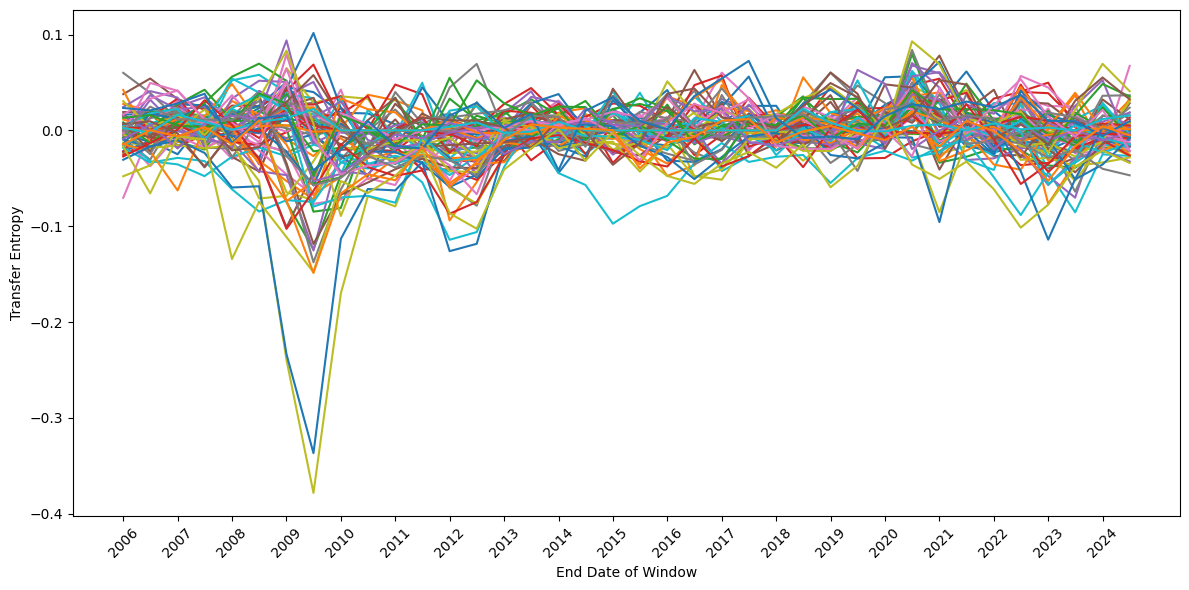

<Figure size 1000x400 with 0 Axes>

interactive(children=(Dropdown(description='asset1', options=('commodity', 'credit', 'currency', 'energy', 'eq…

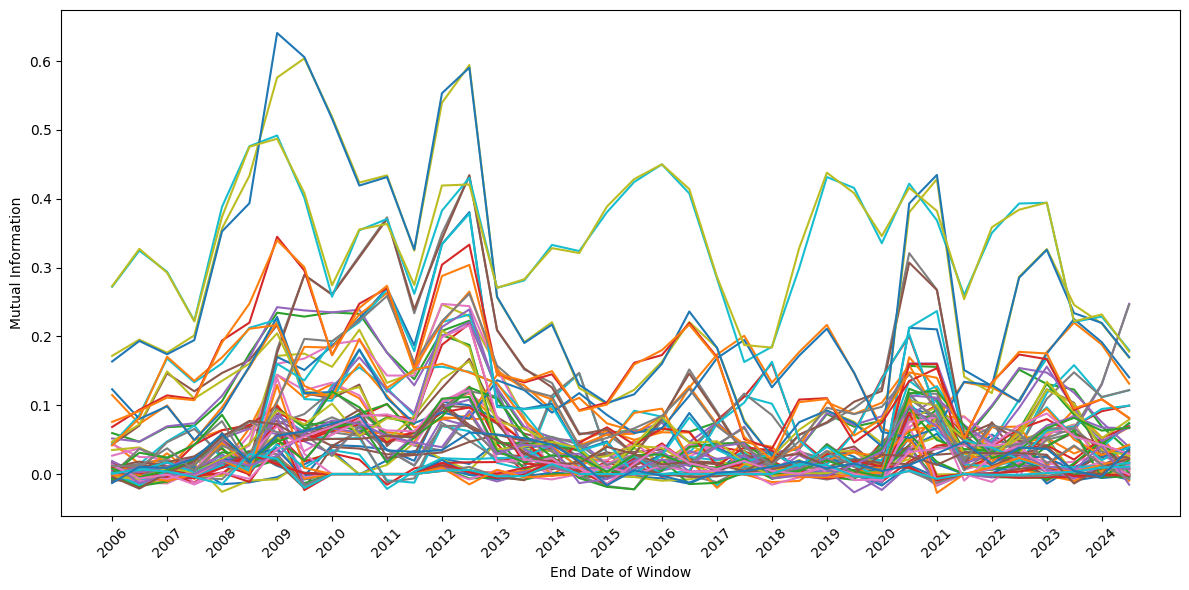

In [ ]:
te_matrix = compute_measure_matrix(windows, eff_transfer_entropy, n_surrogates=10, k=1, l=1)
mi_matrix = compute_measure_matrix(windows, eff_mi)


te_dict = measure_matrix_to_dict(te_matrix, assets)
mi_dict = measure_matrix_to_dict(mi_matrix, assets)


plot_measure_evolution(te_dict, endpoints, assets, "Transfer Entropy")
create_measure_heatmap(te_matrix, assets, endpoints, "Transfer Entropy").show()
create_interactive_pair_plot(te_dict, endpoints, assets, "Transfer Entropy")

plot_measure_evolution(mi_dict, endpoints, assets, "Mutual Information")
create_measure_heatmap(mi_matrix, assets, endpoints, "Mutual Information").show()

In [32]:
import kraskov_jidt

In [33]:
import jpype
print(jpype.getDefaultJVMPath())

C:\Program Files\Java\jdk-23\bin\server\jvm.dll


In [34]:
kraskov_jidt.start_JVM()

In [35]:
def pca_asset_classes(log_returns, tickers, plot_explained_var_ratio=False):
    asset_classes_continuous = {}
    explained_variance_ratios = {}
    asset_classes = tickers.keys()
    for asset_class in asset_classes:
        vals = log_returns[tickers[asset_class]]
        pca, pca_components, explained_variance_ratio = preprocess.compute_pca(vals)
        explained_variance_ratios[asset_class] = explained_variance_ratio
        X = pca_components[:, 0]  # Take first principal component
        asset_classes_continuous[asset_class] = X

    dates = log_returns.index
    asset_classes_continuous = pd.DataFrame(asset_classes_continuous)
    asset_classes_continuous.index = dates
    asset_classes_continuous.index = pd.to_datetime(asset_classes_continuous.index)

    if plot_explained_var_ratio:
        for asset, variance_ratio in explained_variance_ratios.items():
            plt.plot(np.cumsum(variance_ratio), marker="o", label=asset)
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("PCA Explained Variance Ratios")
        plt.legend()
        plt.show()
    return asset_classes_continuous

In [36]:
asset_classes_continuous = pca_asset_classes(log_returns, tickers)

In [37]:
window_len = 2
window_step = 1
windows = preprocess.sliding_window(asset_classes_continuous, 
                                    window_len, 
                                    window_step, 
                                    window_unit="years", 
                                    step_unit="years")
endpoints = [end_date for _, end_date, _ in windows]

In [40]:
te_matrix = plotting.compute_measure_matrix(windows, kraskov_jidt.calc_te_kraskov, 1, 1, 1)

In [42]:
te_dict = plotting.measure_matrix_to_dict(te_matrix, assets)

In [38]:
X = np.random.randint(0, 2, 1000)
Y = np.random.randint(0, 2, 1000)

print(info_theory.transfer_entropy(X, Y, k=1, l=1))
print(kraskov_jidt.calc_te_kraskov(X, Y, 1, 1, 1))

0.0028877986503620485
-0.011471773318417977


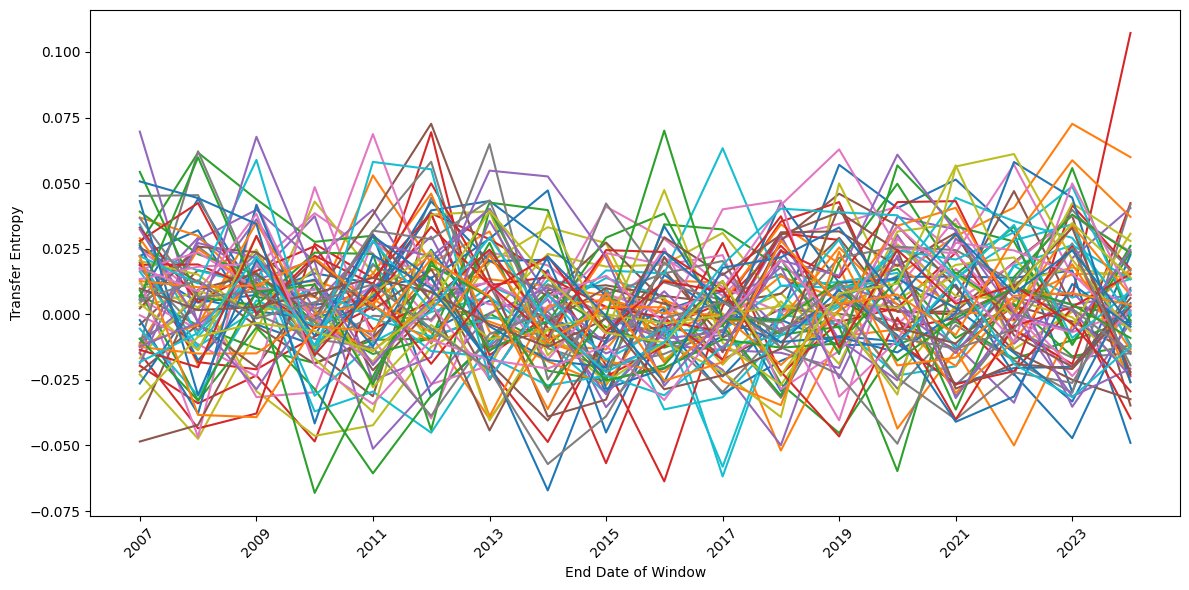

<Figure size 1000x400 with 0 Axes>

interactive(children=(Dropdown(description='asset1', options=('commodity', 'credit', 'currency', 'energy', 'eq…

<function plotting.create_interactive_pair_plot.<locals>.plot_fn(asset1, asset2)>

In [44]:
plotting.plot_measure_evolution(te_dict, endpoints, assets, "Transfer Entropy")
plotting.create_measure_heatmap(te_matrix, assets, endpoints, "Transfer Entropy").show()
plotting.create_interactive_pair_plot(te_dict, endpoints, assets, "Transfer Entropy")